Bibliotecas:

In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

Exportando os dados:

In [139]:
# Caminhos dos dados e criando datasets para cada conjunto

path = r'D:\Python\dataset\train.csv' # dados de treino
path_teste = r'D:\Python\dataset\test.csv' # dados de teste

dados_teste = pd.read_csv(path_teste)
dados = pd.read_csv(path)

dados_backup = dados.copy() # backup de segurança do dataset

dados.head() # visualizando o dataset


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [140]:
y = dados['SalePrice']
dados.drop('SalePrice', axis=1, inplace=True)

Dados faltantes:

In [141]:
# Visualizando dados faltantes

dados_faltantes = (dados.isnull().sum())
print(dados_faltantes[dados_faltantes > 0])

dados_faltantest = (dados_teste.isnull().sum())

# armazenando os índices onde o número de dados faltantes é relativamente grande
print()
miss = dados_faltantes[dados_faltantes > 600]
print('índices onde o número de dados faltantes é relativamente grande:')
print(miss.index)


LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

índices onde o número de dados faltantes é relativamente grande:
Index(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')


In [142]:
# Criando um novo dataset removendo as colunas com um grande número de dados faltantes

dados = dados.drop(miss.index, axis=1)
dados_teste = dados_teste.drop(miss.index, axis=1)

print(dados.shape, dados_teste.shape)

(1460, 75) (1459, 75)


In [143]:
# Separando os dados em dados numéricos e categóricos

dadosn = dados.select_dtypes(exclude='object')
dadosc = dados.select_dtypes('object')

dadosn_teste = dados_teste.select_dtypes(exclude='object')
dadosc_teste = dados_teste.select_dtypes('object')

dadosc.drop('Condition2', axis=1, inplace=True)
dadosc_teste.drop('Condition2', axis=1, inplace=True)


- Dados faltantes numéricos

In [144]:
# removendo dados faltantes restantes com Simple Imputation

impt = SimpleImputer()
dadosn_impt = pd.DataFrame(impt.fit_transform(dadosn))
dadosn_teste_impt = pd.DataFrame(impt.transform(dadosn_teste))

# Redefinindo as colunas

dadosn_impt.columns = dadosn.columns
dadosn_teste_impt.columns = dadosn_teste.columns

- Dados faltantes categóricos

In [145]:
# utilizando One-Hot Encoding para variáveis com cardinalidade < 5
# utilizando Ordinal Encoding para variáveis com cardinalidade > 5

# selecionando as colunas de variáveis com baixa cardinalidade (bc) e alta cardinalidade (ac)

bc_columns = [col for col in dadosc.columns if dadosc[col].nunique() <= 5]
ac_columns = [col for col in dadosc.columns if dadosc[col].nunique() > 5]

print(f'Baixa cardinalidade: {bc_columns}')
print()
print(f'Alta cardinalidade: {ac_columns}')


Baixa cardinalidade: ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'BldgType', 'MasVnrType', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive']

Alta cardinalidade: ['Neighborhood', 'Condition1', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'Foundation', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'Functional', 'GarageType', 'SaleType', 'SaleCondition']


In [146]:
# Ordinal Encoding:

oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

dadosc_oe = pd.DataFrame(oe.fit_transform(dadosc[ac_columns]))
dadosc_teste_oe = pd.DataFrame(oe.transform(dadosc_teste[ac_columns]))

dadosc_oe.columns = dadosc[ac_columns].columns
dadosc_teste_oe.columns = dadosc_teste[ac_columns].columns


In [147]:
# One-Hot Encoding:

ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

dadosc_ohe = pd.DataFrame(ohe.fit_transform(dadosc[bc_columns]))
dadosc_teste_ohe = pd.DataFrame(ohe.transform(dadosc_teste[bc_columns]))

dadosc_ohe.index = dadosc.index
dadosc_teste_ohe.index = dadosc_teste.index

Reunindo os dados tratados:

In [148]:

X = pd.concat([dadosn_impt, dadosc_oe, dadosc_ohe], axis=1)
X_valid = pd.concat([dadosn_teste_impt, dadosc_teste_oe, dadosc_teste_ohe], axis=1)

X.drop(ac_columns, axis=1, inplace=True)
X_valid.drop(ac_columns, axis=1, inplace=True)


In [149]:
# Criando um subgrupo de dados teste/treino para validar e otimizar o modelo

np.random.seed(0)
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.7)


Otimização:

In [164]:
estimators = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350]

optz = []
optz_treino = []

for i in estimators:
    modelo = RandomForestRegressor(n_estimators=i, n_jobs=1, random_state=0)
    modelo.fit(X_treino,y_treino)

    p = modelo.predict(X_teste)
    p_treino = modelo.predict(X_treino)

    er = abs(y_teste - p)/y_teste*100
    er_treino = abs(y_treino - p_treino)/y_treino*100
    mer = np.mean(er)
    mer_treino = np.mean(er_treino)

    optz.append(mer)
    optz_treino.append(mer_treino)



In [165]:
estimatorsS = pd.Series(data= estimators)
optzS = pd.Series(data= optz)
optzS_treino = pd.Series(data= optz_treino)


colunas = ['estimatorsS', 'optzS_treino', 'optzS']
DF = pd.concat([estimatorsS, optzS_treino, optzS], axis=1)

DFf = pd.DataFrame(DF)

print('Média dos erros relativos para cada valor de n_estimators')
DFf

Média dos erros relativos para cada valor de n_estimators


,0,1,2
0,25,4.425561,9.753713
1,50,4.189200,9.801221
2,75,4.126847,9.674629
3,100,4.094467,9.652685
4,125,4.067039,9.624825
5,150,4.039333,9.682840
6,175,4.029235,9.643563
7,200,4.011559,9.673264
8,225,4.014521,9.684332
9,250,4.002587,9.676919


Visualizando melhores parâmetros para o modelo:

Média dos erros relativos X n_estimators


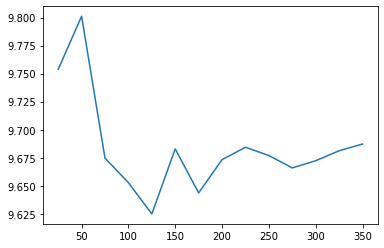

Média dos erros relativos (dados de treino) X n_estimators


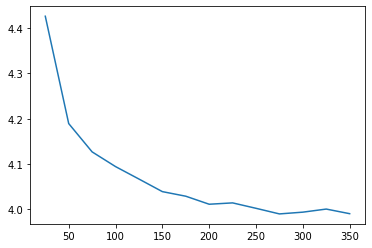

In [166]:
print('Média dos erros relativos X n_estimators')
plt.plot(estimators, optz)
plt.show()
print('Média dos erros relativos (dados de treino) X n_estimators')
plt.plot(estimators, optz_treino)

# Com os gráficos asseguir, vemos que o modelo começa a "overfittar" aproximadamente após n_estimator = 125

Validação cruzada:

In [168]:
# Já com o parâmetro otimizado:

resultados = []
resultados2 = []

k = RepeatedKFold(n_splits=3, n_repeats=5, random_state=0)

for linhas_treino, linhas_teste in k.split(X):

    X_treino, X_teste = X.iloc[linhas_treino], X.iloc[linhas_teste]
    y_treino, y_teste = y.iloc[linhas_treino], y.iloc[linhas_teste]

    modelo = RandomForestRegressor(n_estimators=125, n_jobs=1, random_state=0)
    modelo.fit(X_treino,y_treino)

    p = modelo.predict(X_teste)
    er = abs(y_teste - p)/y_teste*100
    mer = np.mean(er)
    
    resultados.append(mer)



In [169]:
print(f'Média dos erros relativos (em porcentagem): {np.mean(resultados)}')

Média dos erros relativos (em porcentagem): 10.536063160811073


Treinando o modelo final:

In [170]:
# Agora com o modelo validado e optimizado, retreinamos com todo o conjunto de dados

modelo = RandomForestRegressor(n_estimators=50, n_jobs=1, random_state=0)
modelo.fit(X,y)

RandomForestRegressor(n_estimators=50, n_jobs=1, random_state=0)

Previsão do modelo:

In [173]:
# Previsão para os dados teste:

R = modelo.predict(X_valid)

# Por fim armazenamos o resultado em um arquivo .csv

prev = pd.Series(R, index=dados_teste['Id'], name='SalePrice')
prev.to_csv('House_Prices1', header=True)

print(prev)

Id
1461    126459.00
1462    153395.00
1463    178058.80
1464    178567.70
1465    204570.24
          ...    
2915     84964.00
2916     88420.00
2917    151225.74
2918    107771.00
2919    231318.00
Name: SalePrice, Length: 1459, dtype: float64
